https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [10]:
#!pip install scikit-learn==0.24

In [14]:
from pandas import DataFrame, Series, concat, read_csv, datetime
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.metrics import MeanAbsolutePercentageError
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from math import sqrt
from matplotlib import pyplot
import numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [17]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
  early_stop=EarlyStopping(monitor='loss', patience = 30)
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mape', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(X, y, epochs=100, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[early_stop])
    model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]



In [18]:
# load dataset
series = read_csv('https://raw.githubusercontent.com/maiaufrrj/superstore_data/main/df_final.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-36], supervised_values[-36:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [19]:
#df_final carregado do github
series.shape

(48,)

In [20]:
 # fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 

Month=1, Predicted=309768.413966, Expected=162800.893380
Month=2, Predicted=182817.355472, Expected=152661.151440
Month=3, Predicted=173507.938866, Expected=201608.727840
Month=4, Predicted=224958.648566, Expected=187469.961920
Month=5, Predicted=209620.796504, Expected=218960.160420
Month=6, Predicted=241435.805392, Expected=249289.771720
Month=7, Predicted=269617.482263, Expected=174394.028080
Month=8, Predicted=195960.126917, Expected=271669.660860
Month=9, Predicted=294792.768636, Expected=256567.853080
Month=10, Predicted=273357.224815, Expected=239321.099040
Month=11, Predicted=257576.176707, Expected=270723.053560
Month=12, Predicted=290438.642722, Expected=291972.333060
Month=13, Predicted=309953.208715, Expected=206459.195820
Month=14, Predicted=228237.950631, Expected=191062.772160
Month=15, Predicted=215103.466729, Expected=230547.794680
Month=16, Predicted=256289.101952, Expected=233181.348440
Month=17, Predicted=257867.209571, Expected=304509.963360
Month=18, Predicted=329

Test RMSE: 70597.277


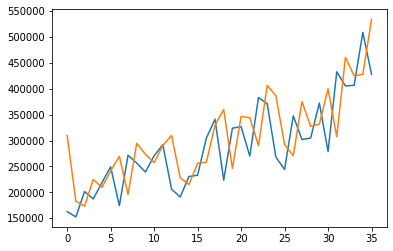

In [21]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-36:], predictions))

print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-36:])
pyplot.plot(predictions)
pyplot.show()

In [23]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape=mean_absolute_percentage_error(raw_values[-36:], predictions)
mape = "%0.2f" % mape
print('Ao longo da série temos uma MAPE de: ' + mape + '%')

Ao longo da série temos uma MAPE de: 21.81%
